In [5]:
import pandas as pd
import seaborn as sns

movies = pd.read_csv('movies.csv')
print('movies: {}'.format(movies.shape), movies.columns.tolist())

ratings = pd.read_csv('ratings.csv')
print('ratings: {}'.format(ratings.shape), ratings.columns.tolist())

movies: (9742, 3) ['movieId', 'title', 'genres']
ratings: (100836, 4) ['userId', 'movieId', 'rating', 'timestamp']


# Data Distribution

## User ratings

,count,mean,std,min,25%,50%,75%,max
users,610.0,165.304918,269.480584,20.0,35.0,70.5,168.0,2698.0


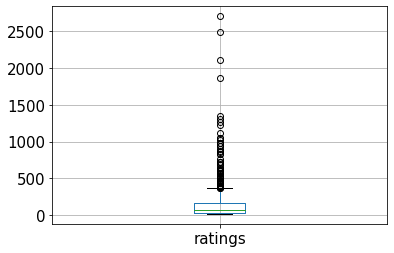

In [6]:
rating_count_user = ratings.groupby('userId').size().reset_index().rename(columns={0:'ratings'})
user_desc = pd.DataFrame(rating_count_user['ratings'].describe()).transpose()
user_desc = user_desc.rename({'ratings':'users'})
boxplot = rating_count_user.boxplot(column=['ratings'], fontsize=15)
user_desc

<AxesSubplot:xlabel='ratings', ylabel='Count'>

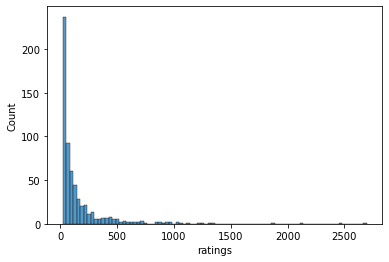

In [7]:
sns.histplot(rating_count_user.ratings)

## Movie ratings

,count,mean,std,min,25%,50%,75%,max
movies,9724.0,10.369807,22.401005,1.0,1.0,3.0,9.0,329.0


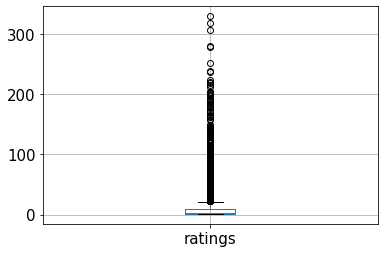

In [8]:
rating_count_movie = ratings.groupby('movieId').size().reset_index().rename(columns={0:'ratings'})
movie_desc = pd.DataFrame(rating_count_movie['ratings'].describe()).transpose()
movie_desc = movie_desc.rename({'ratings':'movies'})
boxplot = rating_count_movie.boxplot(column=['ratings'], fontsize=15)
movie_desc

<AxesSubplot:xlabel='ratings', ylabel='Count'>

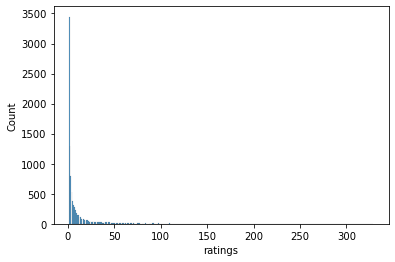

In [9]:
sns.histplot(rating_count_movie.ratings)

# Data filtering
Keep 50% of top users and  25% of top movies

In [10]:
users_to_keep = ratings.groupby('userId').count()
users_to_keep = users_to_keep[users_to_keep['rating'].values>user_desc['50%'].values].index.values

movies_to_keep = ratings.groupby('movieId').count()
movies_to_keep = movies_to_keep[movies_to_keep['rating'].values>movie_desc['75%'].values].index.values

ratings_df = ratings[ratings['userId'].isin(users_to_keep) & ratings['movieId'].isin(movies_to_keep)]
movies_df = movies[movies['movieId'].isin(movies_to_keep)]

print('{} to {} unique users and {} to {} unique movies'.format(ratings['userId'].nunique(), len(users_to_keep), ratings['movieId'].nunique(),len(movies_to_keep)))
print('{} to {} ratings'.format(len(ratings), len(ratings_df)))
ratings_df.head(3)

610 to 305 unique users and 9724 to 2269 unique movies
100836 to 70345 ratings


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


,count,mean,std,min,25%,50%,75%,max
users,305.0,230.639344,215.521158,50.0,98.0,148.0,281.0,1634.0


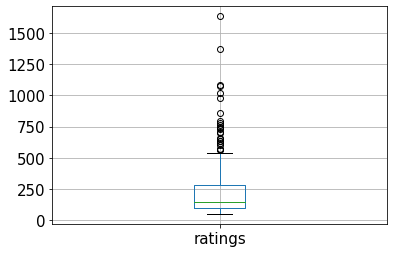

In [11]:
r = ratings_df.groupby('userId').size().reset_index().rename(columns={0:'ratings'})
u = pd.DataFrame(r['ratings'].describe()).transpose()
u = u.rename({'ratings':'users'})
b = r.boxplot(column=['ratings'], fontsize=15)
u

,count,mean,std,min,25%,50%,75%,max
movies,2269.0,31.002644,27.929206,6.0,13.0,20.0,38.0,225.0


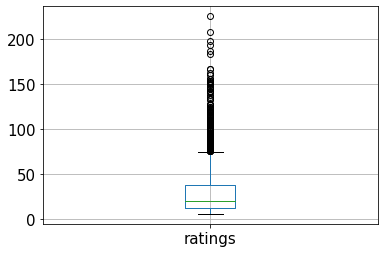

In [15]:
r = ratings_df.groupby('movieId').size().reset_index().rename(columns={0:'ratings'})
m = pd.DataFrame(r['ratings'].describe()).transpose()
m = m.rename({'ratings':'movies'})
b = r.boxplot(column=['ratings'], fontsize=15)
m

# Data processing
## Normalize the ratings
Some people might always rate high, others always low

In [17]:
agg = ratings_df.groupby('userId').mean().rename(columns={'rating':'mean'})
norm_ratings_df = pd.merge(ratings_df,agg['mean'], on='userId')
norm_ratings_df['rating'] = (norm_ratings_df['rating'] - norm_ratings_df['mean'])
norm_ratings_df = norm_ratings_df[['userId', 'movieId','rating', 'mean']]
norm_ratings_df.to_csv('norm_ratings.csv', index=False)
norm_ratings_df

,userId,movieId,rating,mean
0,1,1,-0.383886,4.383886
1,1,3,-0.383886,4.383886
2,1,6,-0.383886,4.383886
3,1,47,0.616114,4.383886
4,1,50,0.616114,4.383886
...,...,...,...,...
70340,610,159093,-0.817408,3.817408
70341,610,164179,1.182592,3.817408
70342,610,166528,0.182592,3.817408
70343,610,168250,1.182592,3.817408


## Load meta data for movies

In [21]:
links = pd.read_csv('links.csv')
m = pd.merge(movies_df, links[['movieId', 'imdbId']], on='movieId')
m['genres'] = m['genres'].str.replace('|', ' ', regex=True).str.lower()
m['date'] = m['title'].str[-5:-1]
m['title'] = m['title'].str[:-6].str.lower()
m.head(3)

,movieId,title,genres,imdbId,date
0,1,toy story,adventure animation children comedy fantasy,114709,1995
1,2,jumanji,adventure children fantasy,113497,1995
2,3,grumpier old men,comedy romance,113228,1995


In [37]:
from imdb import IMDb
ia = IMDb()
def update_info(row):
    print(row.name, end=' ')
    try:
        if not row.isnull().values.any():
            movie = ia.get_movie(row['imdbId'])
            directors = ''
            actors = ''
            for director in movie['directors']:
                if len(directors)==0:
                    directors = director['name'].replace(' ', '')
                    continue
                directors = directors+' '+(director['name'].replace(' ', ''))
            for actor in movie['actors']:
                if len(actors)==0:
                    actors = actor['name'].replace(' ', '')
                    continue
                actors = actors +' '+(actor['name'].replace(' ', ''))
            row['directors'] = directors.lower()
            row['actors'] = actors.lower()
            row['plot'] = movie.get('plot outline').lower()
        pd.DataFrame(row).T.to_csv('movies_meta.csv', mode='a', index=False, header=False)
        return row
    except:
        print('movieId',row['movieId'], 'title',row['title'])
        return row

m1 = pd.read_csv('movies_meta.csv')
m2 = m[~m['movieId'].isin(m1['movieId'])]
m2 = m2.apply(update_info, axis=1)
m1 = pd.concat([m1, m2])
print(m1.shape, m.shape)

90 movieId 176 title living in oblivion 
195 movieId 381 title when a man loves a woman 
307 movieId 720 title wallace & gromit: the best of aardman animation 
332 movieId 801 title harriet the spy 
339 movieId 836 title chain reaction 
981 movieId 2702 title summer of sam 
1417 movieId 4874 title k-pax 
1714 movieId 27611 title battlestar galactica 
1915 movieId 56251 title futurama: bender's big score 
1924 movieId 57504 title girl who leapt through time, the (toki o kakeru shôjo) 
1982 movieId 66934 title dr. horrible's sing-along blog 
2112 movieId 92535 title louis c.k.: live at the beacon theater 
(4137, 8) (2269, 5)


In [19]:
def extract(x, dict_, prefix):
    l = x.split(' ')
    for y in l:
        y = prefix+'_'+y
        if y not in dict_:
            dict_[y] = 0
        dict_[y] += 1



movies_meta = pd.read_csv('movies_meta.csv')
print('{} movies with meta data.'.format(movies_meta.shape))

genres = dict()
movies_meta['genres'].apply(extract, dict_ = genres, prefix = 'g')
genres = pd.DataFrame.from_dict(genres, orient='index').rename(columns={0:'count'})

directors = dict()
movies_meta['directors'].apply(extract, dict_ = directors, prefix = 'd')
directors = pd.DataFrame.from_dict(directors, orient='index').rename(columns={0:'count'})

actors = dict()
movies_meta['actors'].apply(extract, dict_ = actors, prefix = 'a')
actors = pd.DataFrame.from_dict(actors, orient='index').rename(columns={0:'count'})

all_ = pd.concat([genres, directors.head(20), actors.head(20)], axis=0)
print('{} genres, {} directors, {} actors. Saved a total of {} features.'.format(len(genres), len(directors), len(actors), len(all_)))

all_.to_csv('meta_dimensions.csv')
all_.sort_values(by='count',ascending=False)

(4125, 8) movies with meta data.
22 genres, 1840 directors, 144422 actors. Saved a total of 62 features.


,count
g_drama,1800
g_comedy,1665
g_action,1005
g_thriller,980
g_romance,752
...,...
a_spenceraste,1
g_genres,1
a_lisabradley,1
a_kendallcunningham,1


### Binarize genres, directors and actors

In [20]:
import numpy as np

zeros = np.zeros((len(movies_meta), len(all_)))
movies_meta_bin = pd.concat([movies_meta, pd.DataFrame(columns=all_.index, data=zeros).astype(int)], axis=1)

def binarize(row, on_col, prefix, columns):
    l = row[on_col].split(' ')
    for y in l:
        y = prefix+'_'+y
        if y in columns:
            row[y] = 1
    return row

movies_meta_bin = movies_meta_bin.apply(binarize, on_col='genres', prefix='g', columns=movies_meta_bin.columns, axis=1)
movies_meta_bin = movies_meta_bin.apply(binarize, on_col='directors', prefix='d', columns=movies_meta_bin.columns, axis=1)
movies_meta_bin = movies_meta_bin.apply(binarize, on_col='actors', prefix='a', columns=movies_meta_bin.columns, axis=1)

movies_meta_bin = movies_meta_bin.drop(columns=['genres', 'directors', 'actors'])
movies_meta_bin.to_csv('movies_meta_bin.csv', index=False)
movies_meta_bin

,movieId,title,imdbId,date,plot,g_adventure,g_animation,g_children,g_comedy,g_fantasy,...,a_r.leeermey,a_sarahrayne,a_pennjillette,a_jackangel,a_spenceraste,a_gregberg,a_lisabradley,a_kendallcunningham,a_debiderryberry,a_codydorkin
0,1,toy story,114709,1995,a little boy named andy loves to be in his roo...,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,jumanji,113497,1995,"jumanji, one of the most unique--and dangerous...",1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,grumpier old men,113228,1995,things don't seem to change much in wabasha co...,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5,father of the bride part ii,113041,1995,"in this sequel to ""father of the bride"", georg...",0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,6,heat,113277,1995,hunters and their prey--neil and his professio...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4120,183897,isle of dogs,5104604,2018,an outbreak of dog flu has spread through the ...,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4121,184471,tomb raider,1365519,2018,lara croft (alicia vikander) is the fiercely i...,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4122,185029,a quiet place,6644200,2018,in a devastated earth overrun by invincible pr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4123,187541,incredibles 2,3606756,2018,while the parr family has accepted its collect...,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
